In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models
from tqdm import tqdm

from mlfocus import util
from mlfocus.loader import MyData
from mlfocus.model import FocusModel2d

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


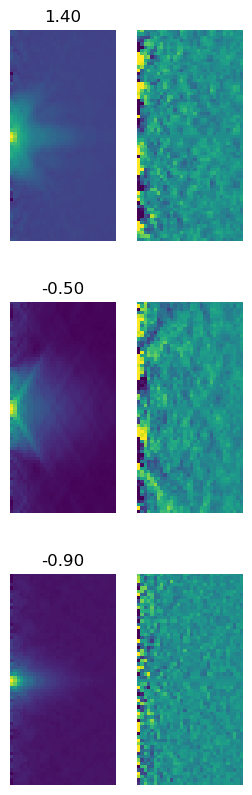

In [19]:
dset = MyData("../mlfocus_data/")

n = 3
fig, axes = plt.subplots(n, 2, figsize=(3, 10))
for n, idx in enumerate(np.random.randint(0, len(dset), size=n)):
    img, label = dset[idx]
    axes[n, 0].set_title(f"{label:.2f}")
    axes[n, 0].imshow(img[0] ** 0.1)
    axes[n, 0].axis("off")
    axes[n, 1].imshow(img[1], vmin=-np.pi / 2, vmax=np.pi / 2)
    axes[n, 1].axis("off")

In [1]:

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_step(model, dataloader, optimizer, criterion, epoch):
    """Basic training loop in pytorch"""
    model.train()
    for batch_idx, (data, target) in tqdm(enumerate(dataloader)):
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)}]\tLoss: {loss.item():.6f}"
            )


/home/lambertt/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


class FocusModel2d(nn.Module):
    def __init__(self):
        super().__init__()
        # num_classes=1, because our output is a single scalar
        # weights=None, because 
        self.model = models.resnet18(weights=None, num_classes=1)
        # 7 and 2 historic to alex net
        self.model.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        return self.model(x)


In [3]:


model = FocusModel2d()
model.to(DEVICE)
# summary(model, (2, 64,32))

dataset = MyData("../mlfocus_data/")
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
epochs = 10

for n in range(epochs):
    train_step(model, loader, optimizer, criterion, n)

0it [00:00, ?it/s]/home/lambertt/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
1it [00:05,  5.78s/it]

Train Epoch: 0 [0/4434]	Loss: 2.005933


101it [06:34,  3.92s/it]

Train Epoch: 0 [1600/4434]	Loss: 1.715024


143it [09:20,  3.92s/it]


KeyboardInterrupt: 